# OpenStreetData Case Study for the Metro Area of Berlin, Germany

## 1. Data Source and Data Wrangling

### 1.1 Map Area  

Berlin Metro Area, Germany.

### 1.2 Data Source

I've downloaded the available data from https://mapzen.com/data/metro-extracts/ (May 2nd, 2016), extracted nodes and ways and imported the data into a sqlite database (See file data_preparation.py, database schama see schema.txt). 

### 1.3 Data Wrangling

The data was directly importet into two SQLite Databasese (data_dirty.db and data_clean.db). SQLite Capabilities were more convinient to inspect and clean the dataset since the sice of the csv files made working with them dificult.

I performed checks on the database to ensure complete integration of all rows. See file integration_tests.py for details.

In [8]:
# Pyhton 3.5

import sqlite3
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint


conn_dirty = sqlite3.connect('data_dirty.db')
c_dirty = conn_dirty.cursor()
conn_clean = sqlite3.connect('data_clean.db')
c_clean = conn_clean.cursor()


def time_from_timestamp(timestamp_input):
    # Helper to get a datetime object from the sql timestamp fields.
    # Precision is limited days.
    year = int(timestamp_input[:4])
    month = int(timestamp_input[5:7])
    day = int(timestamp_input[8:10])
    return datetime.datetime(year, month, day)


def formatnum(num):
    # Helper for printing number with the comma.
    return "{:,}".format(num)

## 2. Data Audit

While evaluating the data the following problems were encountered:

* (nodes table) Columns lat and lon use different precision. 
* (nodes_tags table) Column key has values that are inconsitent like 'addr' and 'address' or 'abbr' and 'abrevation'
* (nodes_tags table) The key 'fixme', 'FIXME' and 'TODO' was found.
* (ways_tags table) The column value holds unexpected values for column key filtered for maxspeed. 250 is unlikely (39 times) as well as 210 or 190. Also the max limit 30 seems to be encoded in various different ways (30, DE:zone30, DE:zone:30, DE:30, PL:zone30, DE:zone(:30), zone30)
* (ways_tags table) The column value holds unexpected values for the column key filtered by postcode. Postcodes are five digits starting (in Berlin) between 10115 and 14199. '66-470' (1,632 times), '74-500' (1,486 times) and '74-505' (938 times) do not match this criteria. There are codes starting with a '0' (mostly area around Berlin) and one code is '39264'.

### 2.1 nodes table : columns lat and lon

An evaluation found, that there are 20 rows in the nodes table, that have a precision of 3 places or less after the dot. This means the precisions is somewhere in the range of about +/- 100 Meters .Therefore, for most uses this would be considered not accurate enough. Most accuracy ist registered 4 places better (7 digits after the dot). Examining the relating nodes_tags and ways_tags for these rows revelead that most rows represented an real world object that had a big 'footprint' and therefore can not be pinpointed to a very precise location. Five rows are villages and eleven are lakes. For the rest we might not rule out the possibilty that just zeros were removed at the end and that the lon and lat actually are the most precise coordinates. No cleaning was applied to lat and lon.

### 2.2 nodes_tags table:  Inconsistent keys

An evaluation of several who share the same beginning of the string showed that some have the same meaning  while others don't. 'art' and 'artist' have different meaning, 'addr' and 'address' do not. The inconsistencies would have to be cleaned manually. Some keys were also formated inconsistent through the use of capital letters ("fixme" and "FIXME"). 

### 2.3 nodes_tags table: fixme and todo keys

'fixme' keys were found. An inspection revealed only problems that coud not be solved programatical.

### 2.4 ways_tags table: maxspeed

The evaluation of the ways_tags table showed that the meaning of the key "maxspeed" is ambigious. I sometimes refers to the speedlimit imposed by law (eg. 30, 50, 100) and sometimes to the technical maxspeed as comissioned (230). Both have a different meaning and should not be mixed into one key. The type of the value also differed often between plain numbers (30, 50, ...), number with a unit or sometimes a long text with a description.

The evaluation also showed that the key to designate a speed limit of 30 kph was predominatly refered to by the value '30'. There were six more differenz kind of values that obviously meant the same (DE:zone30, etc.). Althought there is a difference if it is a speedlimit of 30 or speed limit zone 30, but the maxspeed is same for both cases.

### 2.5 ways_tags table: postcode

My first guess was historical berlin postcodes, but an evaluation showed that the postcodes are correct polish postcodes for a a small town behind the border to germany. The correctly formated (five digit) postcodes are areas around Berlin.

In [2]:
all_postcodes = [n[0] for n in c_dirty.execute("SELECT value FROM ways_tags WHERE key = 'postcode'")]
print('Polish Postcodes:')
print(set([x for x in all_postcodes if len(x) == 6]))

Polish Postcodes:
{'74-406', '74-500', '69-113', '74-503', '74-510', '74-400', '74-404', '66-470', '74-407', '74-520', '69-100', '74-505', '74-311', '74-405', '66-629'}


## 3. Data Cleaning

### 3.1 Inconsistent Key Formating

The key row in the nodes_tags table and ways_tags table was harmonized by turning all key into lower character strings.

### 3.2 ways_tags maxspeed

The maxspeed key values in the table were cleaned in the following way: All maxspeed values greater than 140 were changed to 'no limit'. All other values that contained also literals and the numbers '30' were changed to 30.

### 3.3 postcode - reducing area to Berlin City

All rows in the ways_tags table that contained a longer than 5 digits postcode were removed. If the the postcode was a valid german postcode (5 digit) it was removed, if it wasn't between 10115 and 14199. In a cascade the corresponding rows in ways were removed as well. The same ways applied to the nodes_tags and nodes table.

In [7]:
all_postcodes = [n[0] for n in c_clean.execute("SELECT value FROM ways_tags WHERE key = 'postcode'")]
print('Polish Postcodes in cleaned data:')
print(set([x for x in all_postcodes if len(x) == 6]))

Polish Postcodes in cleaned data:
set()


## 4. Data Overview

### 4.1 File Sizes

* 'berlin.osm':    2.29 GB (uncompressed)
* 'nodes.csv':      833 MB
* 'nodes_tags.csv': 131 MB
* 'ways.csv':        93 MB
* 'ways_nodes.csv': 316 MB
* 'ways_tags.csv':  140 MB

### 4.2 Number of Rows

In [11]:
data = [['table', 'in db', 'before cleaning']]
data.append(['nodes', formatnum(c_clean.execute("SELECT Count(*) FROM nodes").fetchall()[0][0]), formatnum(c_dirty.execute("SELECT Count(*) FROM nodes").fetchall()[0][0])])
data.append(['nodes_tags', formatnum(c_clean.execute("SELECT Count(*) FROM nodes_tags").fetchall()[0][0]), formatnum(c_dirty.execute("SELECT Count(*) FROM nodes_tags").fetchall()[0][0])])
data.append(['ways', formatnum(c_clean.execute("SELECT Count(*) FROM ways").fetchall()[0][0]), formatnum(c_dirty.execute("SELECT Count(*) FROM ways").fetchall()[0][0])])
data.append(['ways_tags', formatnum(c_clean.execute("SELECT Count(*) FROM ways_tags").fetchall()[0][0]), formatnum(c_dirty.execute("SELECT Count(*) FROM ways_tags").fetchall()[0][0])])
pprint(data)

[['table', 'in db', 'before cleaning'],
 ['nodes', '10,399,035', '10,460,000'],
 ['nodes_tags', '3,322,186', '3,658,234'],
 ['ways', '1,465,540', '1,596,861'],
 ['ways_tags', '3,392,952', '4,191,676']]


## 5. Evaluating the contributors

### 5.1 Number of unique contributors

In [12]:
print(formatnum(c_clean.execute("SELECT Count(*) FROM (SELECT uid FROM nodes UNION SELECT uid FROM ways) tmp;").fetchall()[0][0]))

7,727


### 5.2 Top 15 contributors by count

The top 15 constributors each amass considerable rate of above 100,000 each. The top contributor has over 2.3 Mil. Any amount like this can only achieved programaticaly.

In [13]:
statement = """
SELECT user, COUNT(*) FROM nodes
  GROUP BY user
UNION ALL
SELECT user, COUNT(*) FROM ways
  GROUP BY user
ORDER BY COUNT(*) DESC
LIMIT 15;
"""

for n in c_clean.execute(statement).fetchall():
    nr = "{:,}".format(n[1])
    print(n[0], " " * (20 - len(n[0])), " " * (9 - len(nr)), nr)

atpl_pilot             2,370,119
jacobbraeutigam          569,305
streckenkundler          335,365
r-michael                331,568
anbr                     329,294
atpl_pilot               303,445
WegefanHB                281,091
Bot45715                 242,225
Konrad Aust              165,945
toaster                  156,494
Elwood                   151,419
g0ldfish                 145,945
geozeisig                119,321
Polarbear                114,103
Randbewohner             102,982


### 5.3 Top 15 contributor by duration of contribution

Quite a lot of contributors contributet over a longer timeframe. The top list might not be accurate, since old changeset are not included, but an estimation shows many users who made contributions who are many years apart.

In [14]:
statement = """
SELECT user, timestamp 
FROM nodes
UNION
SELECT user, timestamp
FROM ways
"""
users_w_time = [[n[0], time_from_timestamp(n[1])] for n in c_clean.execute(statement).fetchall()]

users = defaultdict(list)

for name, time in users_w_time:
    users[name] += [time]

users_result = []

for name, time_list in users.items():
    users_result.append([name, max(time_list), min(time_list), max(time_list) - min(time_list)])

users_results_sorted = sorted(users_result, key = lambda x: x[3], reverse=True)[:15]

for n in users_results_sorted:
    print("Username:", n[0], " " * (18 - len(n[0])) , "aktive: ", n[3])

Username: Elwood              aktive:  3496 days, 0:00:00
Username: elgolfo             aktive:  3481 days, 0:00:00
Username: Megachip            aktive:  3421 days, 0:00:00
Username: Christopher         aktive:  3333 days, 0:00:00
Username: bahnpirat           aktive:  3316 days, 0:00:00
Username: jorilla             aktive:  3315 days, 0:00:00
Username: IngoWo              aktive:  3310 days, 0:00:00
Username: wasat               aktive:  3303 days, 0:00:00
Username: Streckensucher      aktive:  3294 days, 0:00:00
Username: Protoxenus          aktive:  3260 days, 0:00:00
Username: Pholker             aktive:  3256 days, 0:00:00
Username: J budissin          aktive:  3242 days, 0:00:00
Username: rrissiek            aktive:  3224 days, 0:00:00
Username: BlackMagic          aktive:  3216 days, 0:00:00
Username: Donsen64            aktive:  3204 days, 0:00:00


## 6. Additional Evaluations

### 6.1 Top 15 Amenity

Of the top 15 most were expected. I didn't expect 2,010 hunting stands but the data seems to captures quite a bit of the rural areas around downtown Berlin. Still: More hunting stands than kindergardens. A plotting of the positions of the hunting_stand showed that they are located in the forest like Grunewald and around the city.

In [15]:
statement = """
SELECT value, Count(*)
FROM nodes_tags
WHERE key = 'amenity'
GROUP BY value
ORDER BY Count(*) DESC
LIMIT 15;
"""

for n in c_clean.execute(statement).fetchall():
    print(n[0], " " * (15 - len(n[0])), formatnum(n[1]))

bench            8,850
restaurant       4,592
post_box         3,515
recycling        3,131
waste_basket     2,487
bicycle_parking  2,475
fast_food        2,358
cafe             2,252
hunting_stand    2,010
parking          1,665
kindergarten     1,663
telephone        1,558
vending_machine  1,444
pub              1,130
pharmacy         952


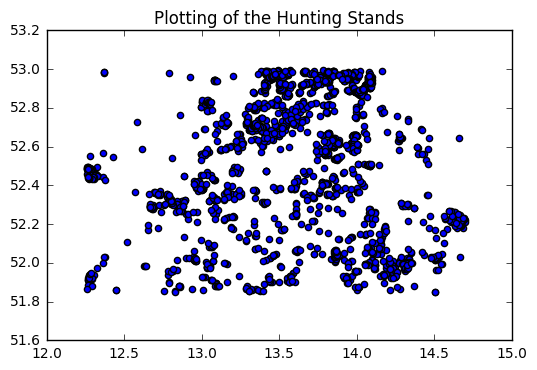

In [18]:
statement = """
SELECT nodes.lon, nodes.lat
FROM nodes_tags
JOIN nodes ON nodes.id = nodes_tags.id
WHERE nodes_tags.value = "hunting_stand"
AND key = 'amenity'
"""

hunting_stands = list(c_clean.execute(statement).fetchall())

df = pd.DataFrame()
df['lat'] = [n[1] for n in hunting_stands]
df['lon'] = [n[0] for n in hunting_stands]

plt.scatter([n[0] for n in hunting_stands], [n[1] for n in hunting_stands])
plt.title('Plotting of the Hunting Stands')
plt.show()

### 6.2 Evaluation of Italian Restaurants

All Italian Restaurants were plotted to see clusters. There is a fair amount places of places (ca. 800). The divide between west and east is still visible. The more detailed map shows in which areas there are more. 

Italian restaurants dominate in the old western part in Charlottenburg in Wilmersdorf, the important and more well of areas before the fall of the wall. 

In the eastern part there are a lot of places in the well-off parts like Mitte, Prenzlauer Berg and Friedrichshein. The areas in the north of the city center (Wedding, Pankow, Moabit, etc.) and in the south (Neukölln) have fewer italian places. The places with fewer places are those were more immigrants live, so italian food might be more a thing for the people without and immigrational background. 

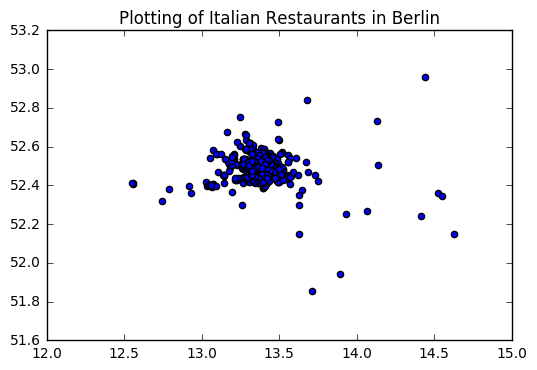

In [20]:
statement = """
SELECT nodes.lon, nodes.lat
FROM nodes_tags
JOIN nodes ON nodes.id = nodes_tags.id
WHERE nodes_tags.value = "italian"
AND key = 'cuisine'
"""

italian_places = list(c_clean.execute(statement).fetchall())

df = pd.DataFrame()
df['lat'] = [n[1] for n in italian_places]
df['lon'] = [n[0] for n in italian_places]

plt.scatter([n[0] for n in italian_places], [n[1] for n in italian_places])
plt.title('Plotting of Italian Restaurants in Berlin')
plt.show()

The following map was created with the script italian_places.py
![title](italian_cluster.png)

## 7. Ideas for Improvement

The data for Berlin is generally on a high level and shows a lot of details. For some values standards are not followed. I would suggest to have an extra key for the maxspeed of the ways (ways_tags) that refers strictly to the speed limit by law. This key should be called 'speedlimit'. Additional information must be provided on the time the speed limit is valid. This change would enable optimized routing based on speed limits not only on the length of the ways. It would also enable owners of car fleets who monitor their fleets to compare their actual speed performance with a legal maximum for the route the vehicle took.